# Modelo: Naive Bayes

https://scikit-learn.org/dev/modules/svm.html

* Algoritmo iterativo.
* Debido a cómo está matemáticamente planteado, el algoritmo converge y no hay óptimos locales. 
    * Podemos decir que llegar a la mejor solucion existente.
* Hay dos parámetros de stop en este algoritmo iterativo:
    * cantidad de iteraciones from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
    * delta de mejora entre iteraciones 
* _Hiperparametro **C**_: podemos dejar de tener una linea que divida perfectamente a los puntos, y lograr obtener a un hiperplano que me divida bastante bien, no perfecto, y que pueda safar en un punto de ruido. Entonces el C nos permite jugar un poco. Permitimos porcentaje pequeño de ruido en la solución de éste problema.
* _Kernels_: nos ayuda a cambiar el producto itnerno. Simula estar en una dimension mas alta y lograr encontrar con un hiperplano y ahorrarnos costo computacional con el mismo kernel.
    * Es decir, solo cambiando el producto interno engañamos para multiplicar altas dimensiones.
    * Kernels más comunes:
        * Lineal: $K(a,b)=a.b+r$
            * con $r$ hiperparametro elegible.  
        * Polinomial: $K(a,b)=(a.b+r)^{d}$ 
            * con $r$ y $d$ hiperparametros elegibles.
            * con $d=1$ sería un kernel lineal.
        * Radial Kernel: RBF (Radial Base Function): $K(a,b)=e^{-\alpha(a-b)^{2}}$
            * con $\alpha$ hiperparametro elegible. 
        * Sigmoid: $K(a,b)=tanh(\alpha.a.b+c)$
            * con $\alpha$ y $c$ hiperparametros elegibles. 



    

# Importación de librerias y datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

Importamos diferentes funciones del preprocessing.py que utilizaremos y el dataset a laburar

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion

df, df_for_prediction = obtener_datasets()

# Kernels a utilizar

Teniendo en cuenta la biblografia de SVM:
https://scikit-learn.org/stable/modules/svm.html#complexity

El algoritmo puede llegar a ser $O(n_{features} \times n_{samples}^2)$ como $O(n_{features} \times n_{samples}^3)$
$O(n_{features} \times n_{samples}^3)$ lo cual para nuestro dataset a entrenar con casi 30k de instancias puede ser un gran problema. La alta dimensionalidad nos juega una gran pasada.

Aunque según la misma biblografia compartida, nos aclara que el caso lineal de SVM (LinearSVC) es muchisimo mas eficiente y puede escalar con millones de datos más.

Al inicio de este notebook se verá reflejado el trabajo realizado con el LinearSVC y habiendo realizado las predicciones de holdout con LinearSVC pero al final del notebooks mostraremos el trabajo realizado con kernels no linieales y demostrar que la alta dimensionalidad nos juega en contra. 



# LinearSVC

In [3]:
from sklearn.svm import LinearSVC

Segun la biblografía de LinearSVC, el mismo es como usar a SVC(kernel='linear') pero que está implementado con la libreria de **liblinear** en vez de **libsvm**. Esto nos permite ser mas flexibles en las seleccion mediante una funcion de perdida y en la penalización de los datos. Es decir, tendremos 2 nuevos hiperparametros a probar:

* Penalty
    * l1
    * l2
* Loss:
    * hinge
    * squared_hinge



## Primer preprocesamiento: conversion_numerica() + get_dataframe_scaled()

### MinMaxScaler()

Además de la **conversion_numerica()** también aplicaremos un escalado com **MinMaxScaler** de los datos con **get_dataframe_scaled()** que es recomendado según la biblografía (https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).
Importamos las funciones nuestras y aplicamos

In [4]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import MinMaxScaler

X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


#### Entrenamiento

En este caso, dividiremos y luego aplicaremos en X_train y X_test la conversión. Esta división recordemos que la hacemos teniendo en cuenta el *stratify* mencionado en otros notebooks.
Tambien como mencionamos en el notebook de árbol de decisión, aplicamos el escalado **después** de la divisón para evitar data leaks.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

Pasamos a definir los hiperparametros a definir. Debido al tiempo de computo, se trabajó previamente con el hiperparametro *C* con valores mas variado y se llegó a la conclusión de que el mejor valor pertencece al rango indicado en la grilla de parametros
Ademas la funcion de perdida y penalidad estaremos variandola, buscando el mejor con GridSearchCV. Recordemos ademas que utilizamos *StratifiedKFold* para tener proporcion de clases razonables.

In [6]:
params = [ {'C':np.arange(60,80,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_1_a = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf_1_a.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.2min finished


[LibLinear]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f52206d76d0>,
             estimator=LinearSVC(dual=False, random_state=10, verbose=True),
             n_jobs=-1,
             param_grid=[{'C': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79]),
                          'loss': ['hinge', 'squared_hinge'],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc', verbose=1)

#### Métricas

Accuracy sobre test:  0.8455396898510671
Los mejores hiperpametros elegidos:  {'C': 75, 'loss': 'squared_hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

  Bajo valor       0.87      0.94      0.90      4945
  Alto valor       0.74      0.55      0.63      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513



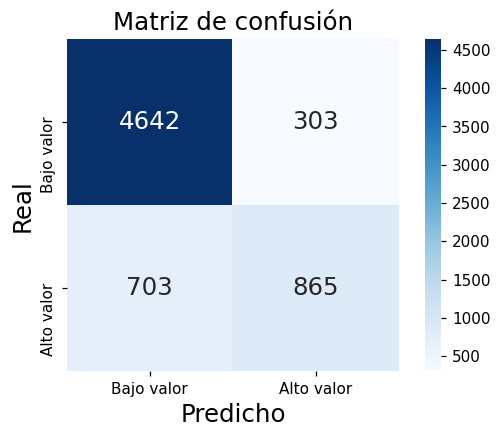

In [7]:
y_pred = clf_1_a.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_1_a.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)

En general, seguimos teniendo el problema de baja precision para los de alto valor. Para conseguir la metrica AUC-ROC, sobre LinearSVC() no es posible aplicar el siguiente método sobre el clasficiador LinearSVC()

In [8]:
# clf_1_a.predict_proba(X_test)[:, 1]

Cuando se entrena con el SVC() tampoco es posible a no ser que se le especifique el parametro 'probability=True'.

Segun la biblografía: https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities
        
        Note: The same probability calibration procedure is available for all estimators via the CalibratedClassifierCV. In the case of SVC and NuSVC, this procedure is builtin in libsvm which is used under the hood, so it does not rely on scikit-learn’s CalibratedClassifierCV.

Por ende utilizaremos 'CalibratedClassifierCV' para predecir la probabilidad de las clases y graficar el AUC-ROC score.
        

AUC-ROC score sobre test:  0.8958852866222323


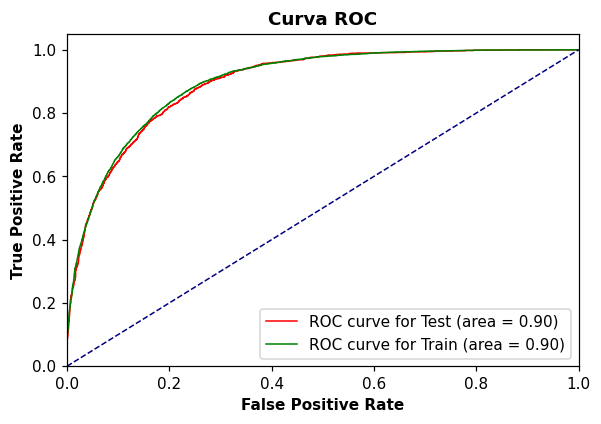

In [9]:
from sklearn.calibration import CalibratedClassifierCV

clf_best=LinearSVC(random_state=10, dual=False, C = 75, loss= 'squared_hinge', penalty='l2')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

Vemos que nos dió 0.8958 el AUC-ROC. Nada mal, y las curvas del grafico nos demustra no hubo overfitting en el train.

### StandarScaler()

Veamos ahora que tal este otro escalado.

In [10]:
from sklearn.preprocessing import StandardScaler

df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


#### Entrenamiento

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, StandardScaler())
X_test = get_dataframe_scaled(X_test, StandardScaler())

In [12]:
params = [ {'C':np.arange(60,80,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_1_b = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf_1_b.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


[LibLinear]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5233c4dd60>,
             estimator=LinearSVC(dual=False, random_state=10, verbose=True),
             n_jobs=-1,
             param_grid=[{'C': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79]),
                          'loss': ['hinge', 'squared_hinge'],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc', verbose=1)

#### Métricas

Accuracy sobre test:  0.8424689083371718
Los mejores hiperpametros elegidos:  {'C': 71, 'loss': 'squared_hinge', 'penalty': 'l1'}
              precision    recall  f1-score   support

  Bajo valor       0.87      0.93      0.90      4945
  Alto valor       0.72      0.57      0.63      1568

    accuracy                           0.84      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.83      0.84      0.84      6513



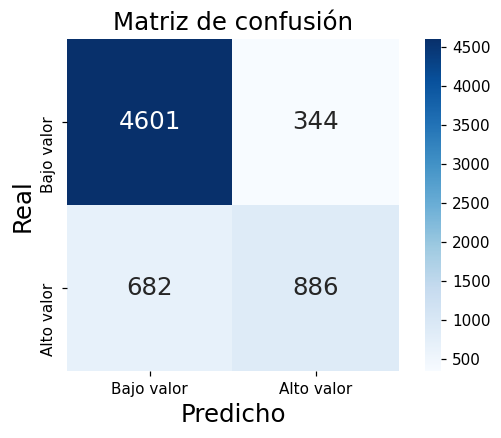

In [13]:
y_pred = clf_1_b.predict(X_test)

print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_1_b.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)

AUC-ROC score sobre test:  0.8955424851942799


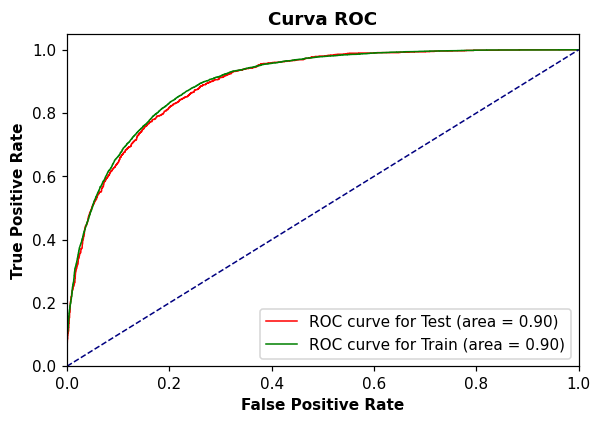

In [14]:
clf_best=LinearSVC(random_state=10, dual=False, C = 71, loss= 'squared_hinge', penalty='l1')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

Vemos que el AUC-ROC empeoró unos leves puntos y además perdimos precisión en ambas clases con respecto al MinMaxScaler().

## Segundo preprocesamietno: get_dataframe_polynomial() + reduccion_numerica()

In [15]:
from preprocessing import get_dataframe_scaled
from preprocessing import get_dataframe_polynomial
from preprocessing import reduccion_numerica

### Entrenamiento

Este preprocesamietno especial lo tratamos en el notebook #0 a la hora de querer visualizar con t-SNE en 2D el dataset al realizarle una expansión con polynomial de features de grado 2 y potencias en False (interaction_only=False), y luego haber aplicado una reducción con TruncatedSVD a esa expansión. No nos habia dado tan mal t-SNE.

Puede que este procesameitno nos de muy bien como muy mal por el hecho de que al hacer una reducción perdemos información, pero por eso tratamos de compensar esa perdida de informacion habiendo expandido el dataset previamente. 

Recordemos que nuestra función de **get_dataframe_polynomial()** solo expande vía PolynomialFeatures a nuestras 4 columnas numéricas. No tiene en cuenta las variables categóricas convertidas numéricamente.

Replicaremos la situación planteada en el notebook #0 con este segundo preprocesameitno. Primero hagamos una expansión con los paramertos mencioandos:

In [16]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r)
X_poly = get_dataframe_polynomial(X_df_numerico, 2, False)

Aplicando 'conversion_numerica' en las variables categóricas.
Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


Luego apliquemos la reducción mencionada, el cual a nuestra funcion le podemos pedir cuanta varianza mantener. En este caso mantengamos el 0.95 que es aquel que usamos previo a graficar t-SNE en 2D en aquel notebook.

In [17]:
X_poly_red = reduccion_numerica(X_poly, 0.95)

Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 24 componentes finales se explica una varianza de: 0.9520266151


Ahora entrenemos otra vez:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_red, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [ {'C':np.arange(0,30,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_2 = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf_2.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   47.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   47.9s finished


[LibLinear]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5233c4df90>,
             estimator=LinearSVC(dual=False, random_state=10, verbose=True),
             n_jobs=-1,
             param_grid=[{'C': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                          'loss': ['hinge', 'squared_hinge'],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc', verbose=1)

### Métricas

In [19]:
y_pred = clf_2.predict(X_test)

Veamos las diferentes métricas y la matriz de confusión:

Accuracy sobre test:  0.8269614616920006
Los mejores hiperpametros elegidos:  {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l1'}
              precision    recall  f1-score   support

  Bajo valor       0.86      0.93      0.89      4945
  Alto valor       0.69      0.51      0.59      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



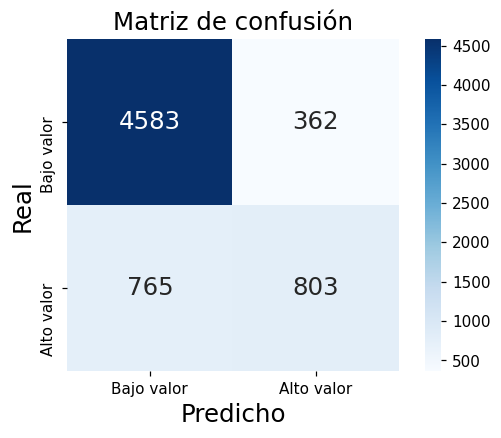

In [20]:
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_2.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)

AUC-ROC score sobre test:  0.8771938388601144


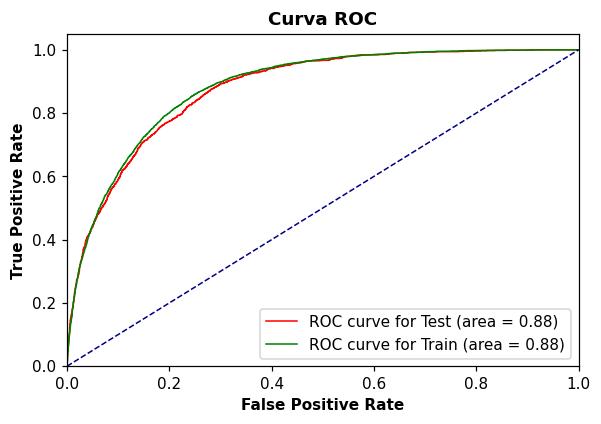

In [21]:
from sklearn.calibration import CalibratedClassifierCV

clf_best=LinearSVC(random_state=10, dual=False, C = 1, loss = 'squared_hinge', penalty ='l1')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

Tal como se sospechaba, empeoró el AUC-ROC pero mejoramos muchisimo en velocidad por dicha reducción realizada. En concluisión podemos ver que las reducciones son bastantes buenas cuando se maneja con un problema de velocidad a la hora de entrenar, aunque se pierda algunos puntos de score al predecir. Es como todo, un trade-off.


## Tercer preprocesamiento: conversion_numerica_generalizada() + MinMaxScaler()

Veamos ahora un preprocesamiento mas general el cual tiene en cuenta variables como las de 'barrios' indicandonos con un booleano si pertenece a palermo o no (habiamos visto que era la variable Palermo predominaba en los barrios con un 90% aproximadamente). Además dejaremos más general la educación alcanzada, sin tener que subdividirla tanto.

In [22]:
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada

df, df_for_prediction = obtener_datasets()
X_df_2, y_df = aplicar_preparacion_generalizado(df)
X_df_numerico_2 = conversion_numerica_generalizada(X_df_2) 
X_df_numerico_2

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,17,39,13,2174,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,17,50,13,0,13,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,13,38,8,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,11,53,6,0,40,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,17,28,13,0,40,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,12,0,38,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32557,13,40,8,0,40,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32558,13,58,8,0,40,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
32559,13,22,8,0,20,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


### Entrenamiento

Dividamos otra vez, apliquemos el escalado de los datos también y luego entrenemos:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_2, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

In [24]:
params = [ {'C':np.arange(60,80,1), 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}]

clf=LinearSVC( random_state=10,verbose=True, dual=False)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_3 = GridSearchCV(clf, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf_3.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.0min finished


[LibLinear]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5233ba0ba0>,
             estimator=LinearSVC(dual=False, random_state=10, verbose=True),
             n_jobs=-1,
             param_grid=[{'C': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79]),
                          'loss': ['hinge', 'squared_hinge'],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc', verbose=1)

### Métricas

In [25]:
y_pred = clf_3.predict(X_test)

Veamos algunas metricas:

Accuracy sobre test:  0.8438507600184247
Los mejores hiperpametros elegidos:  {'C': 76, 'loss': 'squared_hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

  Bajo valor       0.87      0.94      0.90      4945
  Alto valor       0.73      0.55      0.63      1568

    accuracy                           0.84      6513
   macro avg       0.80      0.74      0.77      6513
weighted avg       0.84      0.84      0.84      6513



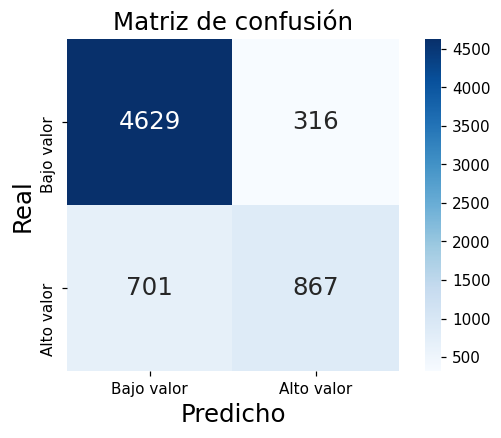

In [26]:
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_3.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)

AUC-ROC score sobre test:  0.8960072274612575


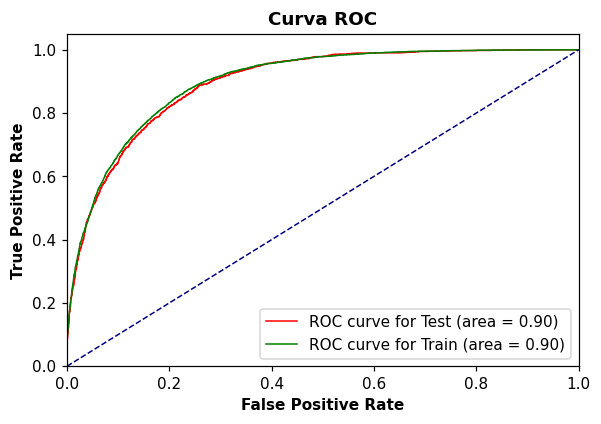

In [27]:
clf_best=LinearSVC(random_state=10, dual=False, C = 76, loss= 'squared_hinge', penalty='l2')
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_cal = CalibratedClassifierCV(clf_best,cv=cv_e) 
clf_cal.fit(X_train, y_train)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_cal.predict_proba(X_test)[:, 1]))
plot_roc_curves(clf_cal, X_test, y_test, X_train, y_train)

Vemos que el AUC-ROC solo mejoró 0.00012 puntos aproximadamente, una diferencia demasiado minima pero nos quedaremos este preprocesamietno y modelo como el mejor obtenido en LinearSVC().

Y además es el que usaremos para predecir en el holdout.

# SVC con distintos Kernels

In [28]:
from sklearn.svm import SVC

SVC tiene un gran problema de tiempo de computo con grandes datos, mas nosotros que tenemos el dataset numérico con las siguientes dimensiones:

In [29]:
X_df_numerico.shape

(32561, 40)

Vamos entonces a pasar a utilizar **RandomizedSearchCV** para acelerar esta búsqueda de hiperparametros, además utilizaremos el parámetro de 'stop' que nos provee sklearn que es el de de '**max_iter**' con SVC, limitando al cantidad máxima de iteraciones.

Ademas para intentar que el computo sea menor, vamos aplicar el preprocesamiento de reducción_numerica() sin haber expandido el dataset tal como habíamos hecho en otro preprocesamiento de LinearSVC()

## Primer preprocessamiento: reduccion_numerica()

Entonces al dataset numérico le aplicaremos una reducción de dimensionalidad bastante profunda, conservando un ~85% de la varianza.

En el notebook de ***#0 - Análisis Exploratorio [Parte 2].ipynb*** habíamos reducido logrando mantener un 95% de la varianza aplicando previamente un preprocesamiento de MinMaxScaler+TruncatedSVD con 22 componentes. Además graficamos con t-SNE con 2 componentes y logramos visualizar una buena reducción de los datos.

Ahora lo haremos simplemente con 15, manteniendo un 85%. Todo para tratar de reducir tiempo de computo demandado por SVC() aunque es muy probable que perdamos demasiada información y tengamos predicciones bastante feas.

In [30]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_numerico = reduccion_numerica(X_df_numerico, 0.84)
X_df_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.
Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 15 componentes finales se explica una varianza de: 0.8451601946


(32561, 15)

### Entrenamiento

Además volvemos a aplicar otro escalado de los datos en el Split realizado, en *X_train* y *X_test* tal como nos recomienda la biblografía (https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use).


Entrenemos entonces con diferentes hiperparaemtros para C, con 3 kernels distintos, y diferentes grados,gamma y coef0 segun corresponda para cada kernel.

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df_r, test_size=0.20, random_state=10, stratify=y_df_r)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [{'C':[1, 100, 300, 500, 700, 1000], 'kernel':['poly', 'rbf', 'sigmoid'], 'degree': [2,3,4] ,'gamma':[0.01,0.03,0.05, 0.07,0.09], 'coef0': [0,0.1,-0.1,0.2,-0.2]}]

clf=SVC(probability = True, random_state=10,verbose=True, cache_size = 5000, tol = 2.0, max_iter = 500)

cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf_4 = RandomizedSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True, random_state=1)
clf_4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


[LibSVM]

/home/feduntu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5233ba0970>,
                   estimator=SVC(cache_size=5000, max_iter=500,
                                 probability=True, random_state=10, tol=2.0,
                                 verbose=True),
                   n_jobs=-1,
                   param_distributions=[{'C': [1, 100, 300, 500, 700, 1000],
                                         'coef0': [0, 0.1, -0.1, 0.2, -0.2],
                                         'degree': [2, 3, 4],
                                         'gamma': [0.01, 0.03, 0.05, 0.07,
                                                   0.09],
                                         'kernel': ['poly', 'rbf', 'sigmoid']}],
                   random_state=1, scoring='roc_auc', verbose=True)

### Métricas

In [32]:
y_pred = clf_4.predict(X_test)

Fue bastante rapido de lo esperado, pero veamos como nos dió el AUC-ROC:

AUC-ROC score sobre test:  0.8392321918656240
Accuracy sobre test:  0.7107323813910640
Los mejores hiperpametros elegidos:  {'kernel': 'poly', 'gamma': 0.07, 'degree': 2, 'coef0': 0.2, 'C': 1}
              precision    recall  f1-score   support

  Bajo valor       0.93      0.67      0.78      4945
  Alto valor       0.45      0.83      0.58      1568

    accuracy                           0.71      6513
   macro avg       0.69      0.75      0.68      6513
weighted avg       0.81      0.71      0.73      6513



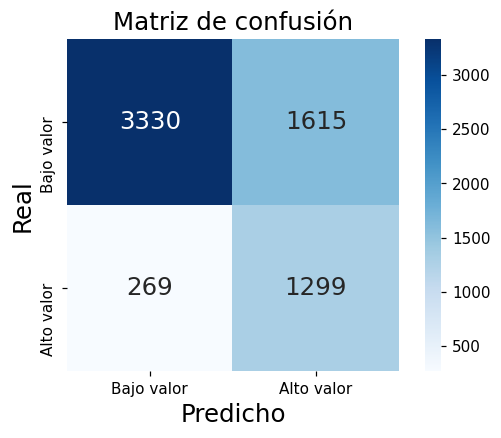

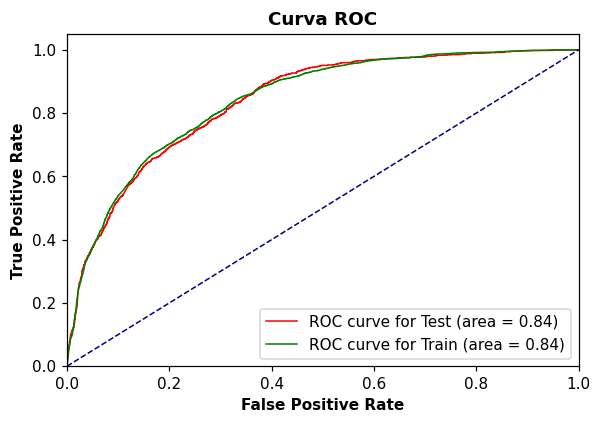

In [33]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_4.predict_proba(X_test)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_4.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_4, X_test, y_test, X_train, y_train)

Lo cual es esperable que tenga este bajo valor a comparación de lo que estábamos acostumbrados a predecir (~0.90). No es mal valor dentro de todo si es mayor a 0.80, pero no nos satisface y tenemos grandes problemas de computo con este modelo por los datos presentados. En esta situación limitamos bastante la búsqueda de hiperparametros con el max iter y también al haber usado RandomizedSearchCV.

## Segundo preprocesamiento: get_dataframe_polynomial() + reduccion_numerica()

Haremos ahora el segundo preprocesamiento que hicimos con LinearSVC() de aplicar un polynomial expansion y luego una reducción. En este caso, haremos la reducción pero manteniendo el 85% de la varianza en vez del 95% que habiamos realizado.
Además tambien haremos una expansion con grado 2.

In [34]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)

X_expand = get_dataframe_polynomial(X_df_r, 2, False)
X_expand.shape

Dataset inicial con 11 features...
Dataset nuevo con PolynomialFeature con 21 features...


(32561, 21)

In [35]:
X_expand_numerico = conversion_numerica(X_expand)
X_expand_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 50)

In [36]:
X_expand_numerico_reducido = reduccion_numerica(X_expand_numerico, 0.85)
X_expand_numerico_reducido.shape

Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 17 componentes finales se explica una varianza de: 0.8652603355


(32561, 17)

### Entrenamiento

Entrenemos entonces:

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_expand_numerico_reducido, y_df_r, test_size=0.20, random_state=10, stratify=y_df_r)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = [{'C':[1, 100, 300, 500, 700, 1000], 'kernel':['poly', 'rbf', 'sigmoid'], 'degree': [2,3,4] ,'gamma':[0.01,0.03,0.05, 0.07,0.09], 'coef0': [0,0.1,-0.1,0.2,-0.2]}]

clf=SVC(probability = True, random_state=10,verbose=True, cache_size = 5000, max_iter = 500)

cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf_5 = RandomizedSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True, random_state=1)
clf_5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[LibSVM]

/home/feduntu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5233a42580>,
                   estimator=SVC(cache_size=5000, max_iter=500,
                                 probability=True, random_state=10,
                                 verbose=True),
                   n_jobs=-1,
                   param_distributions=[{'C': [1, 100, 300, 500, 700, 1000],
                                         'coef0': [0, 0.1, -0.1, 0.2, -0.2],
                                         'degree': [2, 3, 4],
                                         'gamma': [0.01, 0.03, 0.05, 0.07,
                                                   0.09],
                                         'kernel': ['poly', 'rbf', 'sigmoid']}],
                   random_state=1, scoring='roc_auc', verbose=True)

### Métricas

AUC-ROC score sobre test:  0.8404409602567012
Accuracy sobre test:  0.6734223859972363
Los mejores hiperpametros elegidos:  {'kernel': 'poly', 'gamma': 0.07, 'degree': 2, 'coef0': 0.2, 'C': 1}
              precision    recall  f1-score   support

  Bajo valor       0.95      0.60      0.74      4945
  Alto valor       0.42      0.89      0.57      1568

    accuracy                           0.67      6513
   macro avg       0.68      0.75      0.65      6513
weighted avg       0.82      0.67      0.70      6513



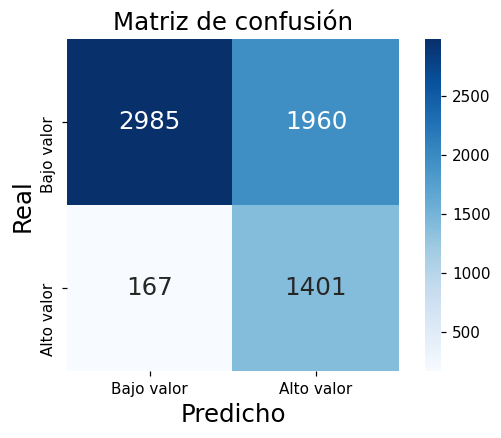

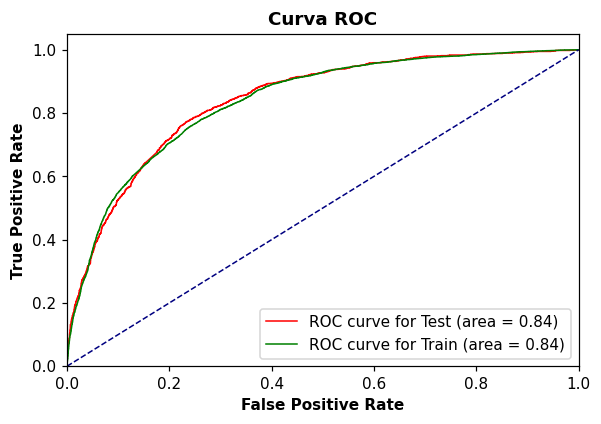

In [38]:
y_pred = clf_5.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test,  clf_5.predict_proba(X_test)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_test, y_pred))
print("Los mejores hiperpametros elegidos: ", clf_5.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_5, X_test, y_test, X_train, y_train)

Tan solo ver la diagonal de la matriz de confusión se puede observar que el modelo es bastante malo. Aunque el AUC-ROC no nos dió tan mal, pero bajó bastante la precision de los de bajo valor.

# Predicción holdout

* Se realizará con el kernel lineal de LinearSVC()